In [1]:
!pip install -U future

     |████████████████████████████████| 829kB 2.7MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=b546a1fe3bd309e3cf2e85479f4a48a02f70b22f8ac4280bcb6242aeedc3295a
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-11-04 16:19:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-04 16:19:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-04 16:19:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [6]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [7]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data


In [8]:
from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score


MAX_SEQ_LEN = 100
MAX_V_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


print("Loading GloVe vectors...")
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec

print("Loaded %s vectors." % len(word2vec))


Loading GloVe vectors...
Loaded 400000 vectors.


In [9]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train.csv


In [12]:
# label text data 

print("Loading text data...")

train = pd.read_csv('train.csv')
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

print("Max sequence length: %s" % max(len(sentence) for sentence in sentences))
print("Min sequence length: %s" % min(len(sentence) for sentence in sentences))
s = sorted(len(s) for s in sentences)
print("Median sequence length: %s" % s[len(s) // 2])

Loading text data...
Max sequence length: 5000
Min sequence length: 6
Median sequence length: 205


In [13]:
# word index

tokenizer = Tokenizer(num_words=MAX_V_SIZE)
tokenizer.fit_on_texts(sentences)
seqs = tokenizer.texts_to_sequences(sentences)
word2idx = tokenizer.word_index
print("Number of unique tokens: %s" % len(word2idx))


Number of unique tokens: 210337


In [15]:
# N x T matrix

data = pad_sequences(seqs, maxlen=MAX_SEQ_LEN)
print("Shape of data tensor:", data.shape)



Shape of data tensor: (159571, 100)


In [18]:
# embedding matrix

print("Filling GloVe vectors...")
num_words = min(MAX_V_SIZE, len(word2idx) + 1) # keras word indexes start at 1; 0 is reserved for padding
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_V_SIZE:
    # get() returns Null if not found
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # oov tokens will be zero
      embedding_matrix[i] = embedding_vector


Filling GloVe vectors...


In [20]:
# embedding layer

embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQ_LEN,
    trainable=False

)

In [22]:
# model definition

input_ = Input(shape=(MAX_SEQ_LEN,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)

In [23]:
# compile model

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [24]:
# fit model

print("Training 1D convnet with global maxpooling...")
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training 1D convnet with global maxpooling...
Epoch 1/10
998/998 [==============================] - 101s 102ms/step - loss: 0.0840 - accuracy: 0.9830 - val_loss: 0.0717 - val_accuracy: 0.9932
Epoch 2/10
998/998 [==============================] - 103s 103ms/step - loss: 0.0675 - accuracy: 0.9922 - val_loss: 0.0715 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 102s 102ms/step - loss: 0.0631 - accuracy: 0.9926 - val_loss: 0.0982 - val_accuracy: 0.9939
Epoch 4/10
998/998 [==============================] - 102s 102ms/step - loss: 0.0598 - accuracy: 0.9934 - val_loss: 0.0671 - val_accuracy: 0.9938
Epoch 5/10
998/998 [==============================] - 102s 102ms/step - loss: 0.0572 - accuracy: 0.9937 - val_loss: 0.0672 - val_accuracy: 0.9941
Epoch 6/10
998/998 [==============================] - 102s 102ms/step - loss: 0.0550 - accuracy: 0.9938 - val_loss: 0.0702 - val_accuracy: 0.9934
Epoch 7/10
998/998 [==============================] - 102s 102ms/step - loss: 

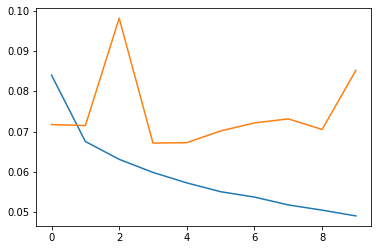

In [25]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

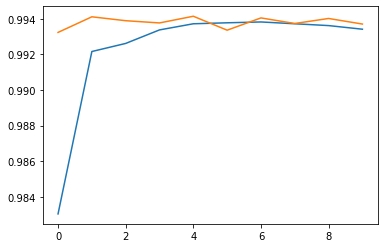

In [28]:
# plot acc per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_accuracy')

In [29]:
# plot mean auc for each label
p = model.predict(data)

aucs = []

for j in range(6):
  auc = roc_auc_score(targets[:,j], p[:,j])
  aucs.append(auc)

print(np.mean(aucs))

0.9756068564934127
